In [1]:
# using test env for this

## Load packages
from __future__ import absolute_import, division, print_function
#..
import numpy as np
import random as rnd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
import os,subprocess,time,copy
import random
import scipy
import math
import matplotlib.gridspec as gridspec
import pathlib
import pandas as pd
#import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
import corner
import pymc
import pandas as pd

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import IPython

# Malcolm's imports
import netCDF4
from multiprocessing.dummy import Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

2.10.0


In [2]:
# Display training progress by printing a single dot for each completed epoch
# Auxilary functions for nn
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
#         if epoch % 100 == 0: print('')
#         print('.', end='')
        print(epoch, end='\r')
        
        
# Monitoring the progress of the model
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    if 'val_mean_squared_error' in hist:
        plt.plot(hist['epoch'], hist['val_mean_squared_error'],
               label = 'Val Error')
    plt.plot(hist['epoch'],0.1+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.2+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.3+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.4+0.*hist['epoch'],'k:')
    plt.legend()
    plt.show()

In [3]:
# ===================  Monthly timeseries controls and constants  ==========================
# After restarting the kernel, run this cell. It should give everything needed

df = pd.read_csv('parameters.txt', delim_whitespace=True)#.drop(['VLHC126kt'])

def julian_to_month(julian_day):
    months = [
        (1, 31), (2, 28), (3, 31), (4, 30), (5, 31), (6, 30),
        (7, 31), (8, 31), (9, 30), (10, 31), (11, 30), (12, 31)
    ]
    for month, days in months:
        if julian_day <= days:
            return month
        julian_day -= days
        
df['month'] = list(map(lambda x: julian_to_month(x), df['julday']))

control = netCDF4.Dataset('timeseries/VLHC000kt/MON.taijVLHC000kt.nc')
control_ant = netCDF4.Dataset('timeseries/VLHC000kt/MON.Antarctica.taijVLHC000kt.nc')

earth_area = control['axyp'][0]
ant_area = control_ant['axyp'][0]
s_molar_mass = 32.065
so2_mmass = 64.066
dms_mmass = 62
su_mmass = 96.06
h2so4_mmass = 98.079
s_per_year = 3.154e7
s_per_month = 2.628e6
# for converting a global flux (kg m^-2 s^-1) to g and tg
flux_to_g = 1e3*s_per_month*earth_area
flux_to_tg = s_per_month*earth_area/1e9

su_dep_vars = []
su_tm_vars = []
so2_dep_vars = ['SO2_wet_dep', 'SO2_dry_dep']
h2so4_dep_vars = ['H2SO4_wet_dep','H2SO4_dry_dep','H2SO4_gs_dep']

# Must include all modes (ACC, AKK, OCC, etc)
for v in control.variables.keys():
    if 'SU_wet_dep' in v or 'SU_dry_dep' in v or 'SU_gs_dep' in v:
        su_dep_vars.append(v)
    if 'SU_Total_Mass' in v and not '_hemis' in v:
        su_tm_vars.append(v)

# Get monthly averages for all 10 years, return 10 years of averages
def get_10yr_monthly_control(control_vals):
    return np.array([np.sum(np.array(control_vals).reshape(10,12), axis=0)/10]*10).flatten()

# start after 10th year because first 10 years are spin-up
su_dep_control_10yr = get_10yr_monthly_control(sum([control[v][120:] for v in su_dep_vars]))
so2_dep_control_10yr = get_10yr_monthly_control(sum([control[v][120:] for v in so2_dep_vars]))
h2so4_dep_control_10yr = get_10yr_monthly_control(sum([control[v][120:] for v in h2so4_dep_vars]))
su_tm_control_10yr = get_10yr_monthly_control(sum([control[v][120:] for v in su_tm_vars]))
so2_tm_control_10yr = get_10yr_monthly_control(control['SO2_Total_Mass'][120:])
h2so4_tm_control_10yr = get_10yr_monthly_control(control['H2SO4_Total_Mass'][120:])

su_dep_control_10yr_ant = get_10yr_monthly_control(sum([control_ant[v][120:] for v in su_dep_vars]))
so2_dep_control_10yr_ant = get_10yr_monthly_control(sum([control_ant[v][120:] for v in so2_dep_vars]))
h2so4_dep_control_10yr_ant = get_10yr_monthly_control(sum([control_ant[v][120:] for v in h2so4_dep_vars]))
su_tm_control_10yr_ant = get_10yr_monthly_control(sum([control_ant[v][120:] for v in su_tm_vars]))
so2_tm_control_10yr_ant = get_10yr_monthly_control(control_ant['SO2_Total_Mass'][120:])

# plt.rcParams["figure.figsize"] = (10,10)

In [4]:
month_names = ['', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

# from https://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
def naive_fast(latvar,lonvar,lat0,lon0):
    latvals = np.array([latvar[:]]*144)
    lonvals = np.array([lonvar[:]]*90).transpose()
    dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
    minindex_flattened = dist_sq.argmin()
    iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
    return iy_min,ix_min

def find_tropopause(row):
    monthname = month_names[int(row['month'])]
    test = netCDF4.Dataset('control_means_2d/' + monthname + '0011-0020.aijlVLHC000kt.nc')
    
    # find gridbox
    lon_idx, lat_idx = naive_fast(test['lat'], test['lon'], row['latitude'], row['longitude'])
    
    tempL = test['TempL'][:,lat_idx,lon_idx]
    z = test['z'][:,lat_idx,lon_idx]
    
    test = netCDF4.Dataset('control_means_2d/' + monthname + '0011-0020.aijVLHC000kt.nc')
    
    ttrop = test['ttrop'][lat_idx,lon_idx]
    ltrop = np.argmin(np.abs(np.array(tempL)-ttrop))
    
    return z[ltrop]

def get_ptrop(row):
    monthname = month_names[int(row['month'])]
    test = netCDF4.Dataset('control_means_2d/' + monthname + '0011-0020.aijVLHC000kt.nc')
    
    # find gridbox
    lon_idx, lat_idx = naive_fast(test['lat'], test['lon'], row['latitude'], row['longitude'])
    
    return test['ptrop'][lat_idx,lon_idx]

def get_stratospheric_so2(row):
    if row['plumetop'] < row['tropopause']:
        return 0
    elif row['plumebottom'] > row['tropopause']:
        return row['SO2']
    else:
        return row['SO2']*(row['plumetop']-row['tropopause'])/row['plumethickness']

def get_stratospheric_so2_pct(row):
    if row['plumetop'] < row['tropopause']:
        return 0
    elif row['plumebottom'] > row['tropopause']:
        return 1
    else:
        return (row['plumetop']-row['tropopause'])/row['plumethickness']
    
df['tropopause'] = df.apply(lambda row: find_tropopause(row), axis=1)
df['ptrop'] = df.apply(lambda row: get_ptrop(row), axis=1)
df['stratospheric_so2'] = df.apply(lambda row: get_stratospheric_so2(row), axis=1)
df['tropospheric_so2'] = df['SO2'] - df['stratospheric_so2']
df['stratospheric_so2_pct'] = df.apply(lambda row: get_stratospheric_so2_pct(row), axis=1)
# df_south = df[df['latitude'] <= -30]
# df_tropic = df[(df['latitude'] > -30) & (df['latitude'] < 30)]
# df_north = df[df['latitude'] >= 30]

In [5]:
su_deps = []
for run in df.index:
    print(run, end='\r')
    test = netCDF4.Dataset('timeseries/'+run+'/MON.Antarctica.taij'+run+'.nc')
    test_su_dep = sum([test[v][:] for v in su_dep_vars])-su_dep_control_10yr_ant
    test_su_dep = test_su_dep*flux_to_tg/su_mmass
    m = int(df.loc[run]['month'])-1
    # shift so it's months since eruption, get first 4 years
    test_4yr_su_dep = np.sum(test_su_dep[m:len(test_su_dep)-12+m].reshape(9,12)[:4], axis=1)
    su_deps.append(test_4yr_su_dep)

params = ['longitude', 'latitude', 'julday', 'plumebottom', 'plumetop', 'H2O', 'stratospheric_so2', 'tropospheric_so2']
X = df[params]
y = np.array(su_deps)

In [6]:
X_scaled = X.copy()
X_scaled['latitude'] = np.sin(X['latitude']*np.pi/180)

bounds = {
    'longitude': [-180,180],
    'latitude': [-1,1],
    'julday': [0,365],
    'plumebottom': [2000,35000],
    'plumetop': [3000,45000],
    'H2O': [0,2000],
    'stratospheric_so2': [2,100],
    'tropospheric_so2': [2,100],
}

bounds_df = pd.DataFrame(bounds)

mmscaler = MinMaxScaler().fit(bounds_df)
X_scaled = mmscaler.transform(X_scaled)
# sscaler = StandardScaler()
# X_scaled = sscaler.fit_transform(X_scaled)
# X_scaled = X

# sscaler = StandardScaler()
# y_scaled = sscaler.fit_transform(y)
mmscaler = MinMaxScaler()
y_scaled = mmscaler.fit_transform(y)
# y_scaled = y

# mmscaler.inverse_transform(X_scaled)

split_index = 110
rf_model = RandomForestRegressor(random_state=6)
rf_model.fit(X_scaled[:split_index], y_scaled[:split_index]);

In [7]:
## Define a nn model for the training
nn_model = keras.Sequential([layers.Dense(32, activation=tf.nn.relu, input_shape=[8]),
                          layers.Dense(32, kernel_initializer='normal',activation='relu'),
                          layers.Dense(32, kernel_initializer='normal',activation='relu'),
#                           layers.Dense(32, kernel_initializer='normal',activation='relu'),
#                               layers.Dense(32, kernel_initializer='normal',activation='relu'),
#                               layers.Dense(32, kernel_initializer='normal',activation='relu'),
                          layers.Dense(4)])

nn_model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_absolute_error', 'mean_squared_error'])

EPOCHS = 1000
nn_model.fit(X_scaled[:split_index], y_scaled[:split_index], epochs=EPOCHS,
                    verbose=0,
                    callbacks=[PrintDot()])

In [8]:
test_nn_score = mean_squared_error(y_scaled[split_index:], nn_model.predict(X_scaled[split_index:]))
test_rf_score = mean_squared_error(y_scaled[split_index:], rf_model.predict(X_scaled[split_index:]))
train_nn_score = mean_squared_error(y_scaled[:split_index], nn_model.predict(X_scaled[:split_index]))
train_rf_score = mean_squared_error(y_scaled[:split_index], rf_model.predict(X_scaled[:split_index]))
print('Train NN: '+str(train_nn_score))
print('Test NN: '+str(test_nn_score))
print('Train RF: '+str(train_rf_score))
print('Test RF: '+str(test_rf_score))

4/4 [==============================] - 0s 1ms/step
Train NN: 0.0003120746
Test NN: 0.012375532
Train RF: 0.002273730948660177
Test RF: 0.014700506981839362


In [9]:
### Define the loglikelihood function
### Need to be double checked
### Users need to define it on their own

def loglike_grad(para, obs, sigma):
    n_para = len(para)
    para = list([para])
    
    para = tf.constant(para)
        ## To be changed in the future, redundant
    sigma_sq = sigma**2
    
    dloglike_dx = np.empty(n_para)
    with tf.GradientTape() as t:
        t.watch(para)
#         log_like = tf.math.reduce_sum(tf.math.divide((obs - tf.constant(rf_model.predict(para)))**2,(sigma_sq * 2)) * (-1))
        log_like = tf.math.reduce_sum(tf.math.divide((obs - nn_model(para))**2,(sigma_sq * 2)) * (-1))
    
    log_like = tf.cast(log_like, tf.float64)
    
#     dloglike_dx = t.gradient(log_like, para)
#     dloglike_dx = tf.cast(dloglike_dx, tf.float64)
    
    return log_like

In [10]:
## The Op that connects pymc with the likelihood function defined above 
class LogLike(pt.Op):
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, obs, sigma):
        # add inputs as class attributes
        self.likelihood = loglike
        self.obs = obs
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (para,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(para, self.obs, self.sigma)

        outputs[0][0] = np.array(logl)

In [16]:
# define obs and uncertainties
case = 11
obs = np.array([y_scaled[case]])
print(obs)
sigma = np.array([0.05,0.05,0.05,0.05])   
## Initiate the loglikelihood function
logl = LogLike(loglike_grad, obs, sigma)

## Start the training
with pm.Model() as opmodel:
    print('in pm.model stuff')
    # set priors
    para = [pm.Uniform(p, lower=min(X_scaled[:,i]), upper=max(X_scaled[:,i])) for i,p in enumerate(X.columns)]
#     para = [pm.Uniform(p, lower=min(bounds[p]), upper=max(bounds[p])) for i,p in enumerate(X.columns)]
    print(para)
    para = pt.as_tensor_variable(para)
    print(para)
    
    pm.Potential("likelihood", logl(para))
    print('calling pm.sample')
    idata_mh = pm.sample(2000, tune=200, cores=1)

[[0.5459732  0.01539329 0.04614894 0.13345093]]
in pm.model stuff
[longitude, latitude, julday, plumebottom, plumetop, H2O, stratospheric_so2, tropospheric_so2]
MakeVector{dtype='float64'}.0
calling pm.sample


Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [longitude]
>Slice: [latitude]
>Slice: [julday]
>Slice: [plumebottom]
>Slice: [plumetop]
>Slice: [H2O]
>Slice: [stratospheric_so2]
>Slice: [tropospheric_so2]


Sampling 2 chains for 200 tune and 2_000 draw iterations (400 + 4_000 draws total) took 668 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [ ]:
# Corner plots:
# https://corner.readthedocs.io/en/latest/

# https://samreay.github.io/ChainConsumer/index.html

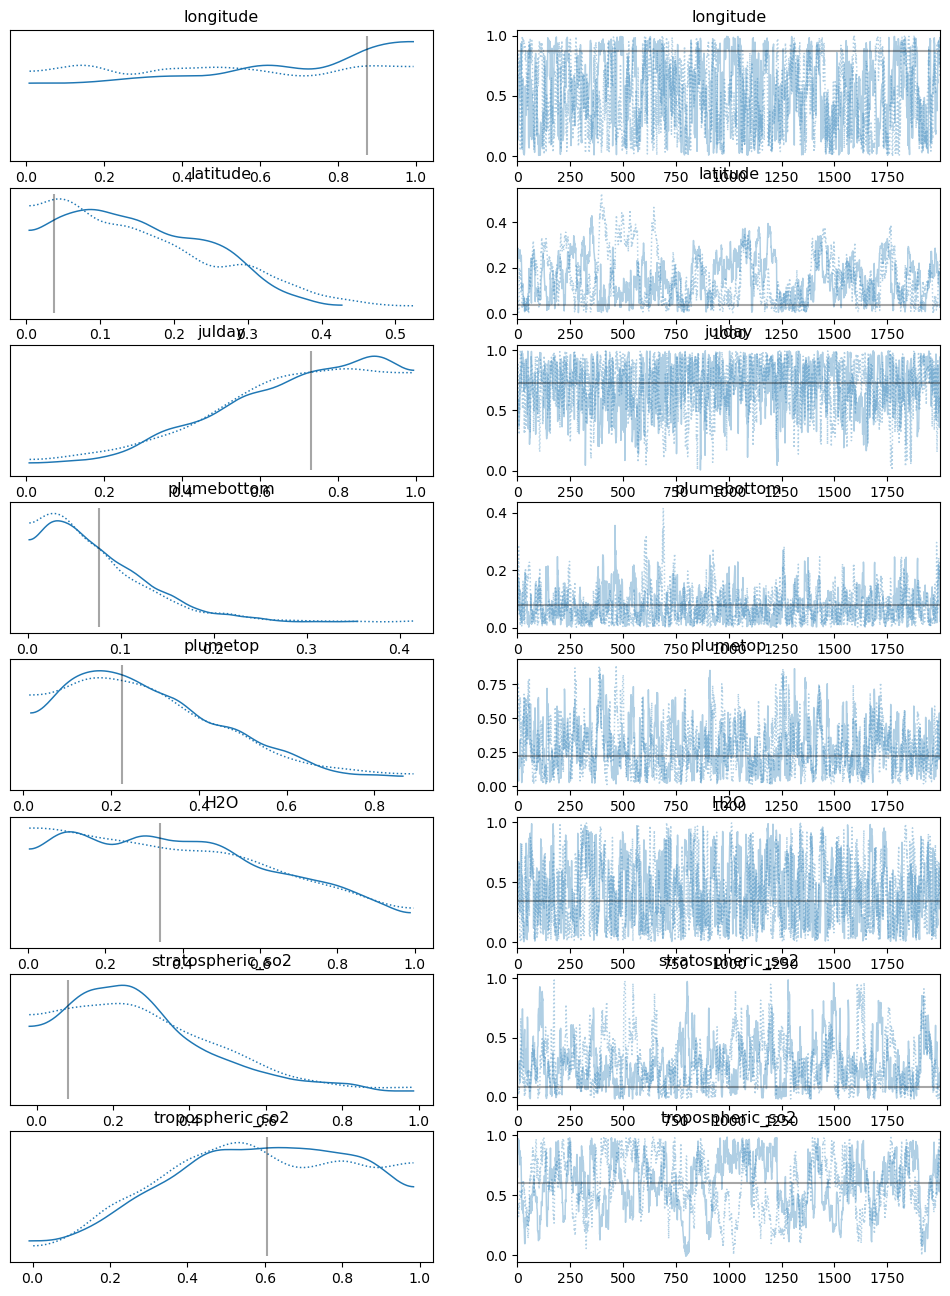

In [18]:
## Check the results
lines = [(p, {}, X_scaled[case][i]) for i,p in enumerate(X.columns)]
az.plot_trace(idata_mh, lines=lines);

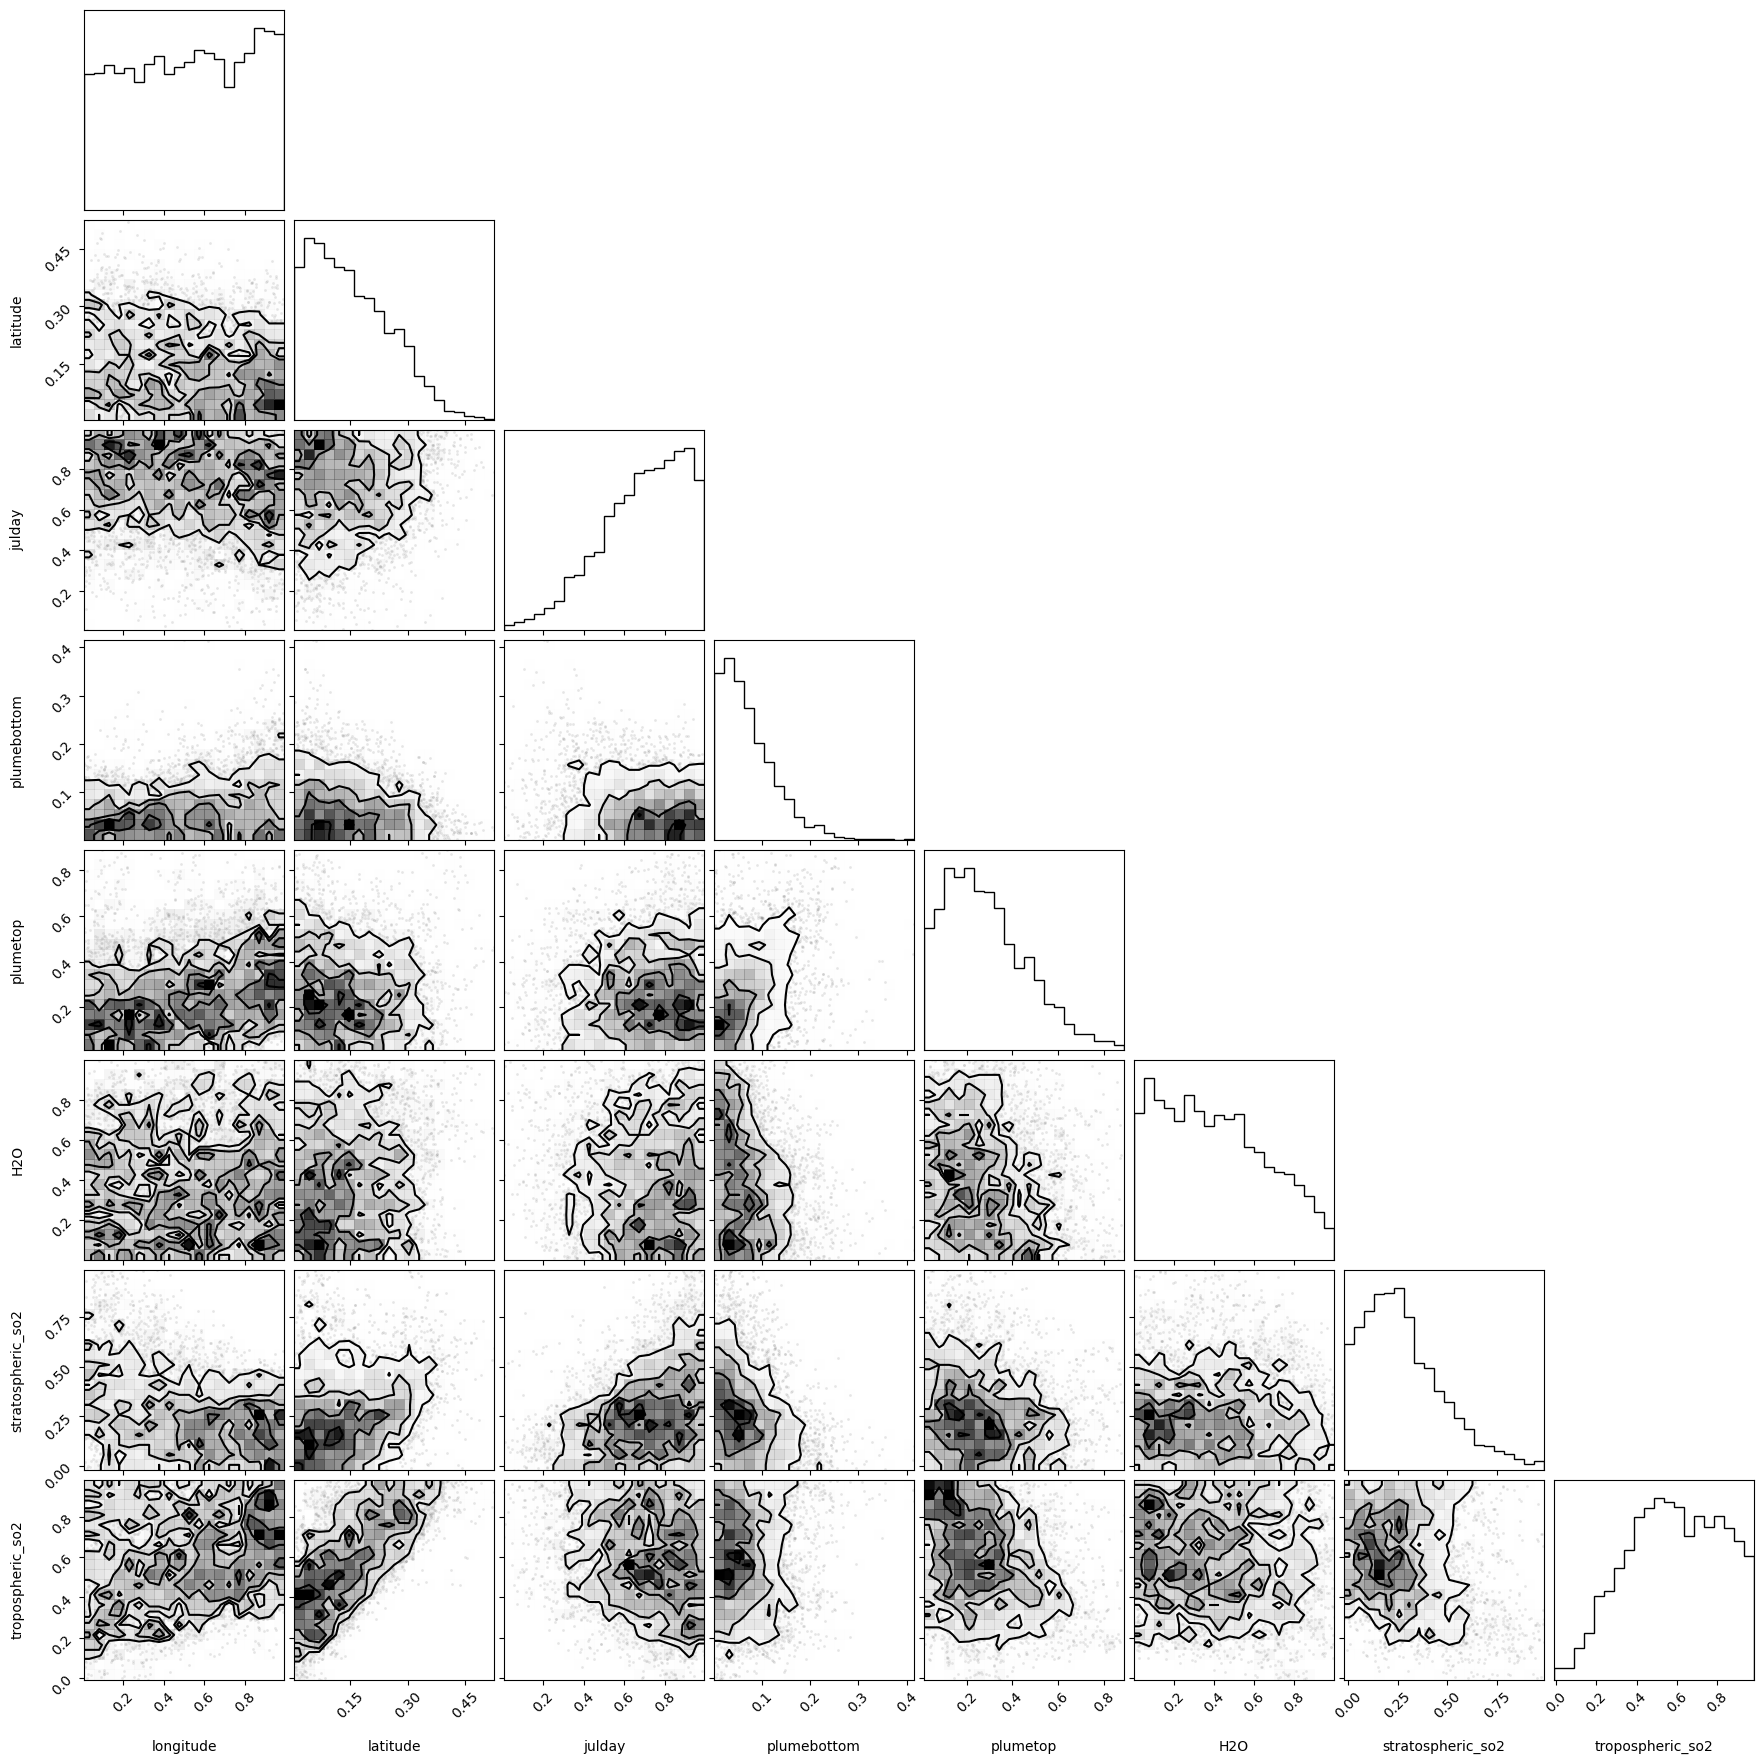

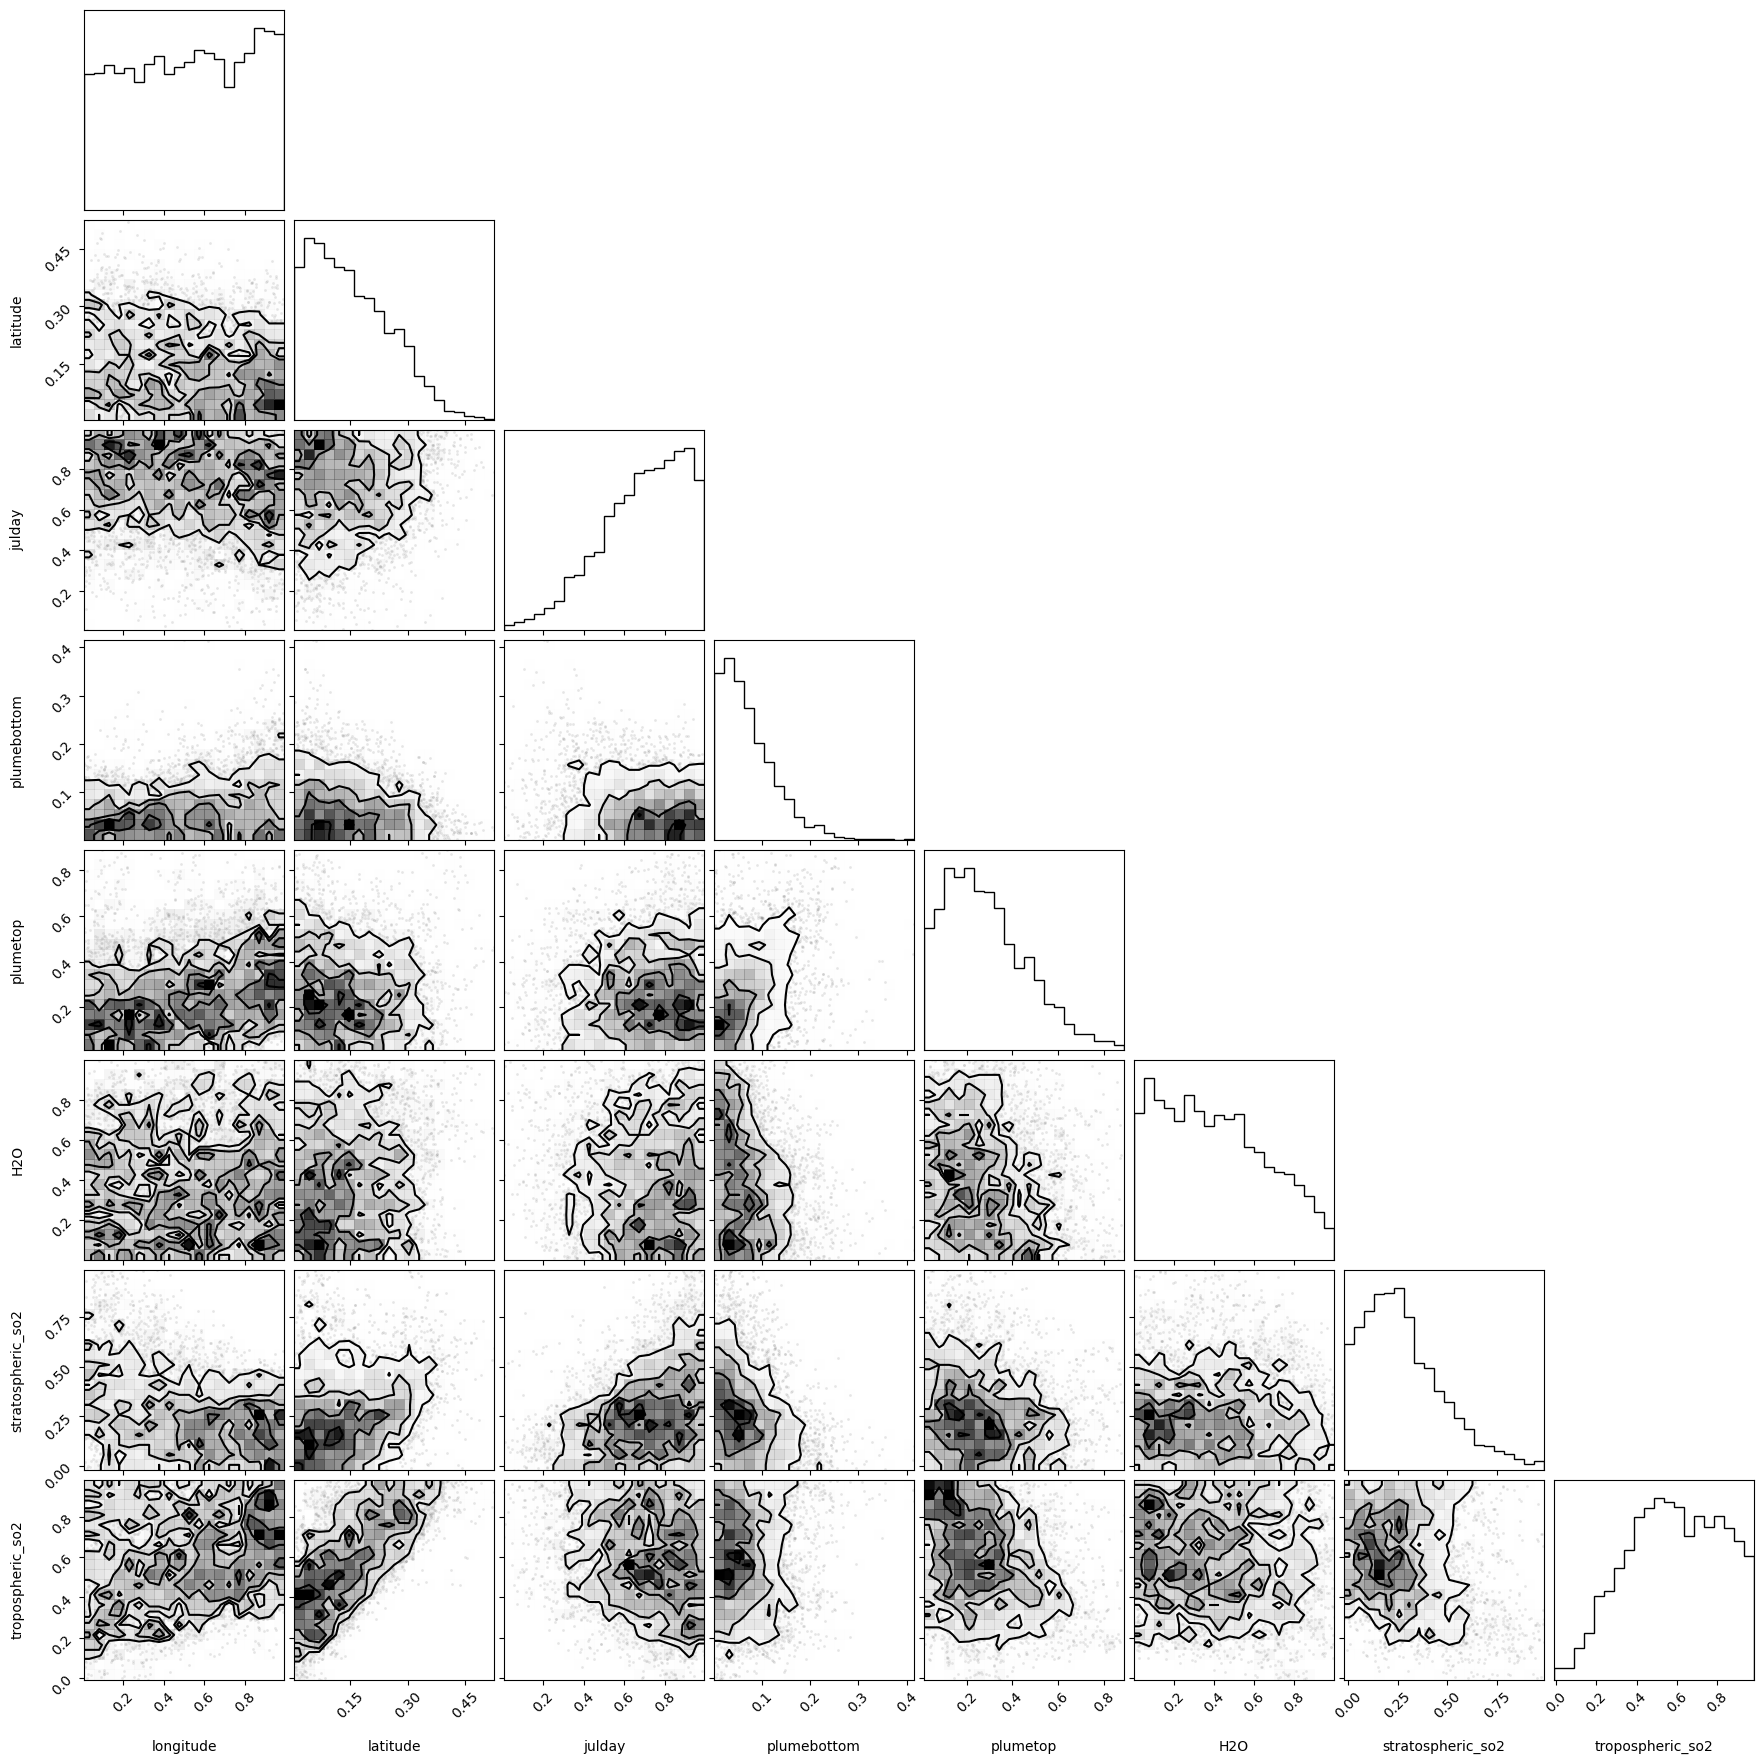

In [20]:
corner.corner(idata_mh)